In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch import Tensor
import torch
from torch.distributions import Normal

from gbi_diff.dataset import SBIDataset
from gbi_diff.diffusion.schedule import VPSchedule

In [2]:
dataset = SBIDataset.from_file("data/two_moons_1000.pt")

theta = dataset._theta
x = dataset._x

<Axes: xlabel='theta_2', ylabel='Count'>

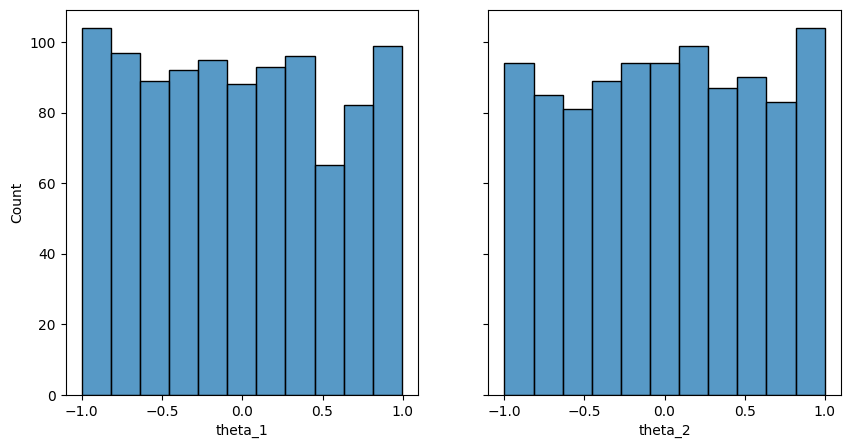

In [3]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5) )
theta_df = pd.DataFrame(theta, columns=[f"theta_{idx + 1}" for idx in range(theta.shape[1])])
sns.histplot(theta_df["theta_1"], ax=ax[0])
sns.histplot(theta_df["theta_2"], ax=ax[1])
# ax[0].hist(theta[:, 0])
# ax[1].hist(theta[:, 1])

In [4]:


def gauss_density(
    x: np.ndarray,
    mean: float = 0,
    std: float = 1,
) -> np.ndarray:
    z = np.sqrt(2 * np.pi * std**2)
    return 1 / z * np.exp(-0.5 * (x - mean) ** 2 / std**2)


def gauss_kl_divergence(
    samples: Tensor,
    n_bins: int = 11,
    samples_per_bin: int = 10,
):
    # true distribution: p = normal gauss / variance preserving schedule
    # incorrect distribution q: diffused samples
    # samples_per_bin: number of samples in a bin
    # sum_s p_s (K log(p_s) - sum_k log(q_{s, k}))
    q, bins = np.histogram(samples, bins=n_bins, density=True)
    
    x = np.linspace(
        bins[0],
        bins[-1],
        n_bins * samples_per_bin,
    )
    p = gauss_density(x, 0, 1)
    q = q[..., None].repeat(samples_per_bin, axis=-1).flatten()
    log_q =  np.where(q > 1e-30, np.log(q), np.log(1e-30))
    log_p =  np.log(p)
    kl_div = p * (log_p - log_q)
    kl_div[p == 0] = 0
    # kl_div[np.isinf(log_q)] == 0
    kl_div = -np.sum(kl_div)
    return kl_div



torch.Size([100, 1000, 100, 2]) torch.Size([1000, 100, 2])


Text(0, 0.5, 'std')

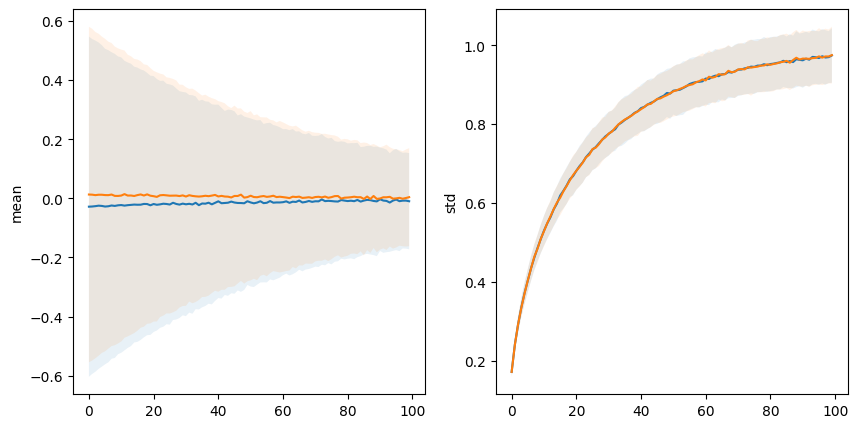

In [5]:
beta = 0.03
T = 100
n_samples = 100

schedule = VPSchedule(beta, beta)
diffused_mean, diffused_std = schedule.forward(theta, torch.linspace(0, 1, T))
diffused_theta = Normal(diffused_mean, diffused_std).sample((n_samples,))
print(diffused_theta.shape, diffused_mean.shape)


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
stds = diffused_theta.std(axis=0)
means = diffused_theta.mean(axis=0)
ax[0].plot(means[..., 0].mean(axis=0))
ax[0].fill_between(np.arange(T), means[..., 0].mean(axis=0) - means[..., 0].std(axis=0), means[..., 0].mean(axis=0) + means[..., 0].std(axis=0), alpha=0.1)
ax[0].plot(means[..., 1].mean(axis=0))
ax[0].fill_between(np.arange(T), means[..., 1].mean(axis=0) - means[..., 1].std(axis=0), means[..., 1].mean(axis=0) + means[..., 1].std(axis=0), alpha=0.1)

ax[1].plot(stds[..., 0].mean(axis=0))
ax[1].fill_between(np.arange(T), stds[..., 0].mean(axis=0) - stds[..., 0].std(axis=0), stds[..., 0].mean(axis=0) + stds[..., 0].std(axis=0), alpha=0.1)
ax[1].plot(stds[..., 1].mean(axis=0))
ax[1].fill_between(np.arange(T), stds[..., 1].mean(axis=0) - stds[..., 1].std(axis=0), stds[..., 1].mean(axis=0) + stds[..., 1].std(axis=0), alpha=0.1)

ax[0].set_ylabel("mean")
ax[1].set_ylabel("std")

In [6]:
from itertools import product

res = np.zeros((n_samples, T, 2))
for sample_idx, diff_time_idx in product(range(n_samples), range(T)):
    res[sample_idx, diff_time_idx, 0] = gauss_kl_divergence(diffused_theta[sample_idx, :, diff_time_idx, 0])
    res[sample_idx, diff_time_idx, 1] = gauss_kl_divergence(diffused_theta[sample_idx, :, diff_time_idx, 1])

/tmp/ipykernel_28677/1514806108.py:28: RuntimeWarning: divide by zero encountered in log
  log_q =  np.where(q > 1e-30, np.log(q), np.log(1e-30))


Text(0.5, 1.0, 'KL Divergence to standard Normal')

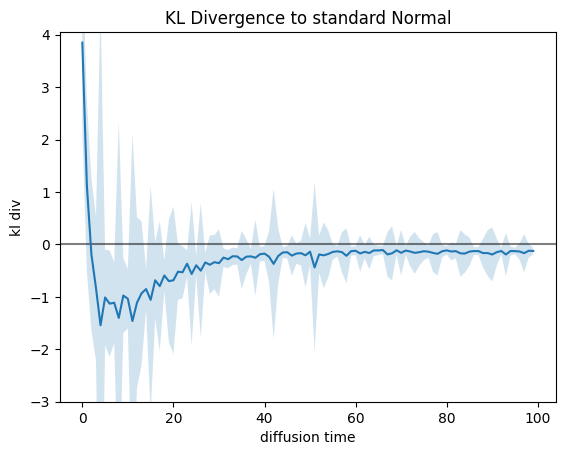

In [7]:
plt.axhline(0, c="k", alpha=0.5)
mean = res[..., 0].mean(axis=0)
std = res[..., 0].std(axis=0)

plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2)
plt.ylim([-3, 4.05])
plt.ylabel("kl div")
plt.xlabel("diffusion time")
plt.title("KL Divergence to standard Normal")

torch.Size([100, 1000, 100, 2])


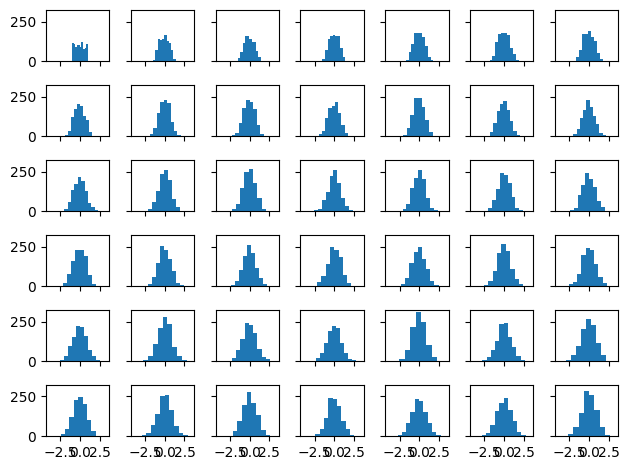

In [8]:
fig, axes = plt.subplots(ncols=7, nrows=6, sharey=True, sharex=True)

print(diffused_theta.shape)
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(theta[:, 0])
    else:
        ax.hist(diffused_theta[0, :, idx - 1, 0])

fig.tight_layout()

In [9]:
gauss_samples = np.random.normal(size=(10000000))


In [10]:
np.log()

TypeError: log() takes from 1 to 2 positional arguments but 0 were given